In [1]:
# Carrega os pacotes
using LinearAlgebra
using Plots
using GaussQuadrature
using DataFrames
using SparseArrays

# Formulação forte

Dada uma função $f:[0,1]\rightarrow\mathbb{R}$ e constantes reais $\alpha>0$ e $\beta\geq 0$, determine $u:[0,1]\rightarrow\mathbb{R}$ tal que
\begin{align*}
\left\{
\begin{aligned}
&-\alpha u_{xx}(x) + \beta u(x) = f(x),\quad x\in]0,1[,
\\
&u(0)=u(1)=0.
\end{aligned}\right.
\end{align*}

Exemplos de solução exata para o problema acima:
*   Ex. 1. Se $f(x)=-2\alpha+\beta x(x-1)$, então $u(x)=x(x-1)$.
*   Ex. 2. Se $f(x)=(\alpha\pi^2+\beta)\sin(\pi x)$, então $u(x)=\sin(\pi x)$.
*   Ex. 3. Se $\alpha=1$, $\beta=0$ e $f(x)=8$, então $u(x)=-4x(x-1)$.
*   Ex. 4. Se $\alpha=\beta=1$ e $f(x)=x$, então $\displaystyle u(x)=x+(e^{-x}-e^x)/(e-e^{-1})$.

In [2]:
function exemplo1()
    α = 1.0
    β = 1.0
    f(x) = -2.0 * α + β * x *(x-1.0)
    u(x) = x * (x - 1.0)
    return α, β, f, u
end
function Exemplo2()
    α = 1.0 
    β = 1.0
    f(x) = (α*π^2 + β) *sin(π*x)
    u(x) = sin(π*x)
    return α, β, f, u
end
function Exemplo3()
    α = 1.0 
    β = 0.0
    f(x) = 8.0
    u(x) = -4.0 * x * (x - 1.0)
    return α, β, f, u
end
function Exemplo4()
    α = 1.0 
    β = 1.0
    f(x) = x
    u(x) = x + (exp(-x) - exp(x)) / (exp(1) - exp(-1))
    return α, β, f, u
end

"Retorna os valores de `α`, `β`, `f` e `u` de acordo com o exemplo escolhido."
function dados_de_entrada(exemplo)
    if exemplo == 1
        return exemplo1()
    elseif exemplo == 2
        return Exemplo2()
    elseif exemplo == 3
        return Exemplo3()
    elseif exemplo == 4
        return Exemplo4()
    else
        error("Exemplo inválido. Escolha 1, 2, 3 ou 4.")
    end
end

dados_de_entrada

# Problema aproximado - via o método das diferenças finitas

Considere a discretização uniforme do intervalo $[0,1]$, dada por $0 = x_0 < x_1 < \dots < x_N < x_{N+1} = 1$, onde cada subintervalo tem comprimento $h=1/(N+1)$.

Para $i \in \{1, 2, \dots, N\}$, a aproximação da segunda derivada de $u$ no ponto $x_i$ pode ser obtida usando as seguintes expansões em série de Taylor:

\begin{align*}
& u(x_i + h) = u(x_i) + h u'(x_i) + \frac{h^2}{2} u''(x_i) + \frac{h^3}{6} u'''(x_i) + \frac{h^4}{24} u^{(4)}(x_i) + \frac{h^5}{120} u^{(5)}(x_i) + O(h^6), \\
& u(x_i - h) = u(x_i) - h u'(x_i) + \frac{h^2}{2} u''(x_i) - \frac{h^3}{6} u'''(x_i) + \frac{h^4}{24} u^{(4)}(x_i) - \frac{h^5}{120} u^{(5)}(x_i) + O(h^6).
\end{align*}

Ao somar essas duas expressões, obtemos:

\begin{align*}
& u(x_i + h) + u(x_i - h) = 2 u(x_i) + h^2 u''(x_i) + \frac{h^4}{12} u^{(4)}(x_i) + O(h^6).
\end{align*}

Dessa forma, a aproximação para a segunda derivada é dada por:

\begin{align*}
& \frac{u(x_{i+1}) - 2 u(x_i) + u(x_{i-1})}{h^2} = u''(x_i) + \frac{h^2}{12} u^{(4)}(x_i) + O(h^4) \equiv u''(x_i) + O(h^2).
\end{align*}

Substituindo a aproximação acima na equação $-\alpha u_{xx}(x_i) + \beta u(x_i) = f(x_i)$, temos que 
\begin{align*}
-\alpha \frac{u(x_{i+1}) - 2 u(x_i) + u(x_{i-1})}{h^2} + \beta u(x_i) \approx f(x_i), \quad \forall i\in\{1, 2, \dots, N\}.
\end{align*}

Sob tais consideração, definimos o seguinte problema aproximado: determine $U_i\equiv U(x_i)\in\mathbb{R}$ tal que
\begin{align*}
\left\{
\begin{aligned}
&-\alpha \frac{U_{i+1} - 2 U_i + U_{i-1}}{h^2} + \beta U_i = f(x_i), \quad  i\in\{1, 2, \dots, N\},
\\
&U_0=U_{N+1}=0.
\end{aligned}\right.
\end{align*}

Reescrevendo este sistema na forma matricial, temos
\begin{align*}
\begin{bmatrix}
2\alpha + \beta h^2 & -\alpha & 0 & \cdots & 0 \\
-\alpha & 2\alpha + \beta h^2 & -\alpha & \cdots & 0 \\
0 & -\alpha & 2\alpha + \beta h^2 & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & -\alpha \\
0 & 0 & 0 & -\alpha & 2\alpha + \beta h^2
\end{bmatrix}
\begin{bmatrix}
U_1\\
U_2\\
U_3\\
\vdots\\
U_{N}
\end{bmatrix}=
\begin{bmatrix}
h^2f(x_1)+\alpha U_0\\
h^2f(x_2)\\
h^2f(x_3)\\
\vdots\\
h^2f(x_{N-1})\\
h^2f(x_N)+\alpha U_{N+1}
\end{bmatrix}
\end{align*}

In [3]:
"Retorna a matriz `A` e o vetor `b` de acordo com o exemplo escolhido."
function monta_A_b(α, β, f, N)
    h = 1.0 / (N+1) # Passo da malha 

    diag_principal = fill(2.0*α + β*h^2, N) # Diagonal principal
    diag_superior_infeiror = fill(-α, N-1) # Diagonal superior e inferior

    A = SymTridiagonal(diag_principal, diag_superior_infeiror)  # Cria a matriz tridiagonal
    b = h^2 * f.(h:h:1-h) # Cria o vetor b

    return A, b
end

monta_A_b

## Comparando a solução aproximada com a solução exata

"Matriz A:"

3×3 SymTridiagonal{Float64, Vector{Float64}}:
  2.0  -1.0    ⋅ 
 -1.0   2.0  -1.0
   ⋅   -1.0   2.0

"Vetor b:"

3-element Vector{Float64}:
 0.5
 0.5
 0.5

"Solução aproximada U:"

3-element Vector{Float64}:
 0.75
 0.9999999999999999
 0.7499999999999999

"Erro da solução aproximada:"

1.1102230246251565e-16

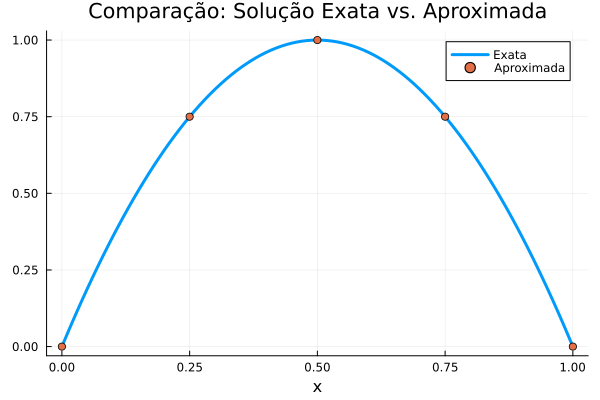

In [4]:
# Carrega o exemplo escolhido
exemplo = 3
α, β, f, u = dados_de_entrada(exemplo)

# Define o número de nós internos na malha
N = 3

# Constrói a matriz A e o vetor b com base nos parâmetros α, β e na função f
A, b = monta_A_b(α, β, f, N)

# Exibe a matriz A (sistema linear) e o vetor b (termo fonte)
display("Matriz A:")
display(A)
display("Vetor b:")
display(b)

# Resolve o sistema linear A * U = b para obter a solução aproximada U
U = A \ b
display("Solução aproximada U:")
display(U)

# Calcula o erro da solução aproximada
erro = maximum(abs.(U - u.(LinRange(1/(N+1), 1-1/(N+1), N))))
display("Erro da solução aproximada:")
display(erro)

# Define a discretização da malha com N nós internos, incluindo os pontos de fronteira
malha = LinRange(0, 1, N+2)

# Gera o gráfico comparando a solução aproximada com a solução exata
plt = plot(0:0.01:1, u.(0:0.01:1), label="Exata", lw=3, title="Comparação: Solução Exata vs. Aproximada")
plot!(plt, malha, [0; U; 0], label="Aproximada", lw=3, seriestype=:scatter) # O "!" adiciona ao gráfico existente
xlabel!("x")  # Adiciona o rótulo ao eixo x

# Exibe o gráfico final
display(plt)

## Estudo da convergência do erro

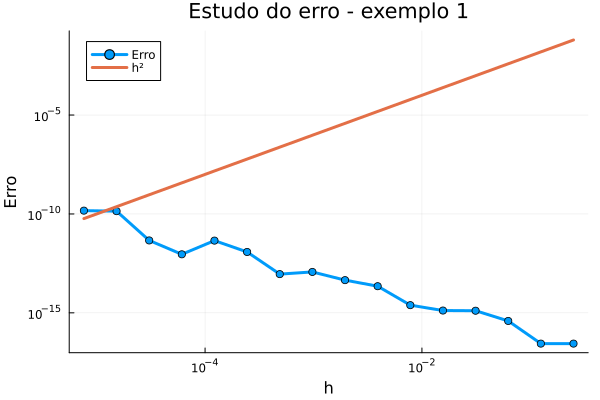

"Tabela com os valores de h e erro - exemplo 1"

Row,h,erro
,Float64,Float64
1,0.25,2.77556e-17
2,0.125,2.77556e-17
3,0.0625,3.88578e-16
4,0.03125,1.27676e-15
5,0.015625,1.30451e-15
6,0.0078125,2.44249e-15
7,0.00390625,2.21767e-14
8,0.00195312,4.49363e-14
9,0.000976562,1.16851e-13


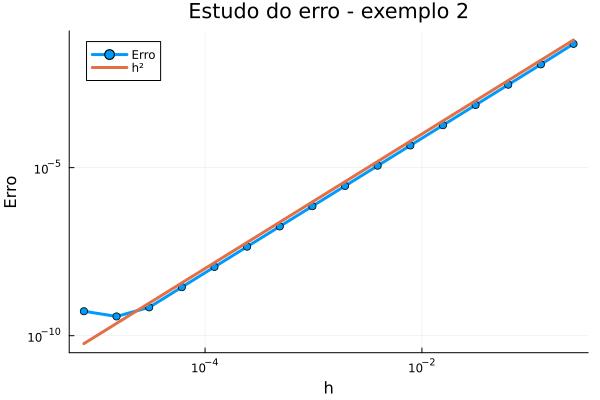

"Tabela com os valores de h e erro - exemplo 2"

Row,h,erro
,Float64,Float64
1,0.25,0.0479168
2,0.125,0.0117453
3,0.0625,0.00292196
4,0.03125,0.000729595
5,0.015625,0.000182343
6,0.0078125,4.55822e-5
7,0.00390625,1.13953e-5
8,0.00195312,2.84882e-6
9,0.000976562,7.12204e-7


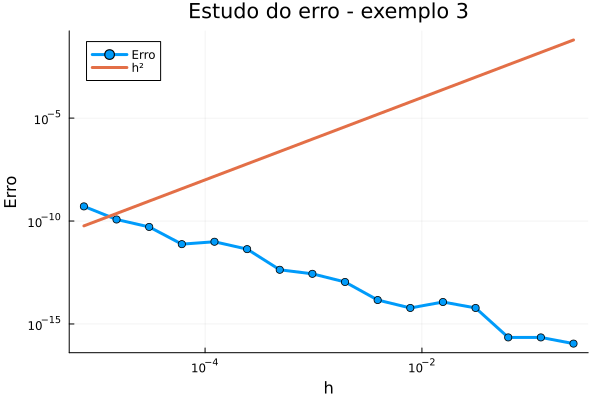

"Tabela com os valores de h e erro - exemplo 3"

Row,h,erro
,Float64,Float64
1,0.25,1.11022e-16
2,0.125,2.22045e-16
3,0.0625,2.22045e-16
4,0.03125,5.9952e-15
5,0.015625,1.16573e-14
6,0.0078125,5.9952e-15
7,0.00390625,1.45439e-14
8,0.00195312,1.09468e-13
9,0.000976562,2.72782e-13


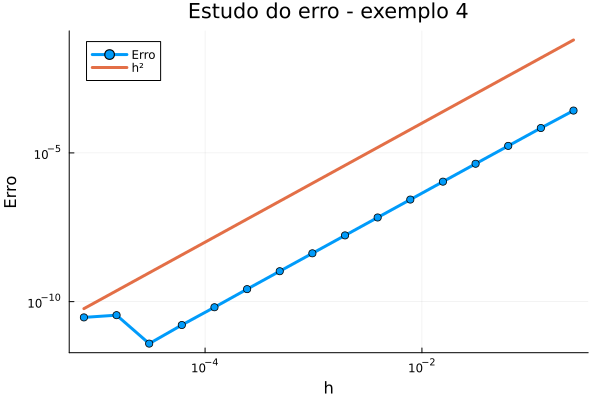

"Tabela com os valores de h e erro - exemplo 4"

Row,h,erro
,Float64,Float64
1,0.25,0.000264735
2,0.125,6.85766e-5
3,0.0625,1.72054e-5
4,0.03125,4.3176e-6
5,0.015625,1.0795e-6
6,0.0078125,2.69881e-7
7,0.00390625,6.7474e-8
8,0.00195312,1.68685e-8
9,0.000976562,4.21717e-9


In [5]:
function estudo_do_erro(exemplo)
    # Carrega o exemplo escolhido
    α, β, f, u = dados_de_entrada(exemplo)
    # Define os valores de N a serem considerados
    vec_N = [2^i-1 for i in 2:17]
    # Inicializa o vetor para armazenar os erros
    vec_erros = zeros(length(vec_N))
    # Calcula o erro para cada valor de N
    for i = 1:length(vec_N)
        N = vec_N[i]
        h = 1.0 / (N+1)
        A, b = monta_A_b(α, β, f, N)
        U = A \ b
        vec_erros[i] = maximum(abs.(U - u.(h:h:1-h)))
    end
    # Exibe o gráfico do erro em função dos h's em escala logarítmica
    h = 1.0 ./ (vec_N .+ 1) # Calcula o tamanho do passo h para cada N
    plt = plot(h, vec_erros, lw=3, linestyle=:solid, markershape=:circle, label="Erro", title="Estudo do erro - exemplo "*string(exemplo),  xscale=:log10, yscale=:log10, legend=:topleft) # Gráfico do erro
    plot!(plt, h, h.^2, lw=3, linestyle=:solid, label="h²")# Adiciona a curva h² ao gráfico
    xlabel!("h")     # Adiciona o rótulo ao eixo x 
    ylabel!("Erro")  # Adiciona o rótulo ao eixo y
    display(plt)     # Exibe o gráfico
    # Exibir a tabela com os valores de h e erro
    display("Tabela com os valores de h e erro - exemplo "*string(exemplo))
    display(DataFrame(h=h, erro=vec_erros))
end

estudo_do_erro(1)
estudo_do_erro(2)
estudo_do_erro(3)
estudo_do_erro(4)

# Problema aproximado - via o método de Galerkin

Dados $f:[0,1]\rightarrow\mathbb{R}$ e constantes reais $\alpha>0$ e $\beta\geq 0$, determine $u_h\in V_m=[\varphi_1,\varphi_2,\dots,\varphi_{m}]$ tal que
$$
  \alpha \int_0^1\frac{du_h}{dx}(x)\frac{dv_h}{dx}(x)dx
+ \beta  \int_0^1 u_h(x)v_h(x)dx
= \int_0^1f(x)v_h(x)dx,
\quad \forall v_h\in V_m.
$$

## Formulação matricial

Tomando $\displaystyle u_h(x) = \sum_{j=1}^{m} c_j\varphi_j(x)$ e $v_h=\varphi_i$, para $i=1,2,\dots,m$, temos a forma matriz-vetor do problema aproximado, isto é, determinar um vetor $c\in\mathbb{R}^m$ tal que
\begin{align*}
Kc=F,
\end{align*}
em que, para $i,\,j\in\{1,2,\dots,m\}$,
$$
K_{i,j} = 
  \alpha \int_0^1\frac{d\varphi_i}{dx}(x)\frac{d\varphi_j}{dx}(x)dx
+ \beta  \int_0^1 \varphi_i(x)\varphi_j(x)dx
\quad\text{e}\quad
F_i = 
\int_0^1f(x)\varphi_i(x)dx.
$$

### Cálculo da matriz K - considerando a base linear por partes

Para cada $i\in\{1,\dots,m\}$, defina

\begin{align*}
\varphi_i(x) = 
\begin{cases}
\displaystyle
\frac{x-x_{i-1}}{h},& \forall x\in[x_{i-1},x_{i}],
\\ 
\displaystyle
\frac{x_{i+1}-x}{h},& \forall x\in[x_{i},x_{i+1}],
\\
0,&\forall x\notin[x_{i-1},x_{i+1}].
\end{cases}
\qquad\hbox{e}\qquad
\frac{d\varphi_i}{dx}(x) = 
\begin{cases}
\displaystyle
\frac{1}{h},& \forall x\in]x_{i-1},x_{i}[,
\\
\displaystyle
-\frac{1}{h},& \forall x\in]x_{i},x_{i+1}[,
\\
0,&\forall x\notin]x_{i-1},x_{i+1}[.
\end{cases}
\end{align*}

Segue o gráfico de cada função base:

<div style="text-align: center;">
    <img src="./imagens/Fig01.png" alt="img" style="width: 80%;">
</div>

Nesse caso específico de funções base lineares por parte, os únicos elementos possivelmente não nulos da matriz $K$ são $K_{i,i}$, $K_{i,i+1}$ e $K_{i+1,i}$. 
Ademais, dado que $K$ é uma matriz simétrica, basta calcular $K_{i,i}$ e $K_{i,i+1}$.

$$
K_{i,i} = 
 \frac{2\alpha}{h}
+\frac{2\beta h}{3}
\qquad\text{e}\qquad
K_{i,i+1} = 
-\frac{\alpha}{h}
+\frac{\beta h}{6}.
$$

In [6]:
"Constrói e retorna a matriz tridiagonal simétrica `K` de tamanho `m x m`"
function monta_K(α::Float64, β::Float64, m::Int) :: SymTridiagonal{Float64}
    h = 1.0 / (m + 1)  # Tamanho do passo

    diag_principal = fill(2.0*α/h + 2.0*β*h/3.0, m)     # Diagonal principal
    diag_superior_infeiror  = fill(-α/h + β*h/6.0, m-1) # Diagonal superior e inferior

    K = SymTridiagonal(diag_principal, diag_superior_infeiror)  # Cria a matriz tridiagonal

    return K
end

monta_K

### Cálculo do vetor força F - considerando a base linear por partes

No caso em que $f(x) = 8$, temos que 
$$
F_i 
= 
\int_0^1 f(x)\varphi_i(x)dx
=
8\int_0^1\varphi_i(x)dx
=
8\int_{x_{i-1}}^{x_{i+1}}\varphi_i(x)dx
=
8h.
$$

Já no caso em $f(x) = x$, obtemos
$$ 
F_i
= 
\int_0^1 f(x)\varphi_i(x)dx 
= 
\int_0^1 x\varphi_i(x)dx
= 
hx_i.$$

Para o caso de uma função $f$ geral, vamos aproximar a integral via o método da quadratura Gaussiana. 
Note que

\begin{align*}
F_i 
= &
\int_0^1 f(x)\varphi_i(x)dx
\\[7pt]
=& 
  \int_{x_{i-1}}^{x_{i}} f(x)\frac{x-x_{i-1}}{h}dx
+ \int_{x_{i}}^{x_{i+1}} f(x)\frac{x_{i+1}-x}{h}dx
\\[7pt]
=& 
  \int_{-1}^1 f\big(x(\xi,i)\big)\frac{x(\xi,i)-x_{i-1}}{h}\frac{h}{2}d\xi
+ \int_{-1}^1 f\big(x(\xi,i+1)\big)\frac{x_{i+1}-x(\xi,i+1)}{h}\frac{h}{2}d\xi
\\[7pt]
=& 
\frac{h}{2}
\int_{-1}^1 f\big(x(\xi,i)\big)\frac{\xi+1}{2}d\xi
+ \frac{h}{2}
\int_{-1}^1 f\big(x(\xi,i+1)\big)\frac{1-\xi}{2}d\xi
\\[7pt]
=& 
\frac{h}{2}
\int_{-1}^1 f\big(x(\xi,i)\big)\phi_2(\xi) d\xi
+ \frac{h}{2}
\int_{-1}^1 f\big(x(\xi,i+1)\big)\phi_1(\xi)d\xi
\\[7pt]
\approx& 
\frac{h}{2}
\sum_{j=1}^{n_{pg}}W_j\Big[
  f\big(x(P_j,i)\big)\phi_2(P_j)
+ f\big(x(P_j,i+1)\big)\phi_1(P_j)
\Big],
\end{align*}

em que $\{P_1,P_2,\dots,P_{n_{pg}}\}$ e $\{W_1,W_2,\dots,W_{n_{pg}}\}$ são os pontos e pesos de gauss, respectimente.
Quanto a mudança de variável, segue os detalhes no gráfico abaixo:
<div style="text-align: center;">
    <img src="./imagens/Fig02.png" alt="img" style="width: 80%;">
</div>

onde, $\phi_1(\xi)=(1-\xi)/2$ e $\phi_{2}(\xi)=(1+\xi)/2$.

In [7]:
"Retorna o valor de `x` para um dado `ξ`." 
function x_de_ξ(ξ,i,h)
    return (h/2) * (ξ + 1.0) + (i-1) * h
end

"Retorna o valor de `φₐ(ξ)` para um dado `ξ` e `a`."
function ϕ(ξ, a)
    if a == 1
        return (1.0 - ξ) / 2.0
    elseif a == 2
        return (1.0 + ξ) / 2.0
    else
        error("a deve ser 1 ou 2.")
    end
end


"Monta e retorna o vetor força `F` de tamanho `m`, utilizando a quadratura de Gauss-Legendre para calcular as integrais associadas."
function monta_F(f::Function, m::Int) :: Vector{Float64}
    h = 1.0 / (m + 1)  # Tamanho do passo
    F = zeros(m)       # Inicializa o vetor F
    P, W = legendre(5) # Define 5 pontos de quadratura de Gauss-Legendre

    # Loop sobre as funções de base
    for i = 1:m
        # Loop sobre os pontos de quadratura
        for j = 1:5
             # Cálculo das coordenadas em x correspondentes aos pontos de referência P[j]
            x1 = x_de_ξ(P[j],i,h)
            x2 = x_de_ξ(P[j],i+1,h)
            # Calcula e acumula a contribuição da quadratura no vetor F[i]
            F[i] += W[j] * ( f(x1) * ϕ(P[j],2) + f(x2) * ϕ(P[j],1) ) * h/2
        end
    end
    return F
end

monta_F

## Comparando a solução aproximada com a solução exata

"Matriz K:"

3×3 SymTridiagonal{Float64, Vector{Float64}}:
  8.0  -4.0    ⋅ 
 -4.0   8.0  -4.0
   ⋅   -4.0   8.0

"Vetor F:"

3-element Vector{Float64}:
 1.9999999999999996
 1.9999999999999996
 1.9999999999999996

"Solução aproximada U:"

3-element Vector{Float64}:
 0.7499999999999998
 0.9999999999999997
 0.7499999999999998

"Solução exata nos nós internos:"

3-element Vector{Float64}:
 0.75
 1.0
 0.75

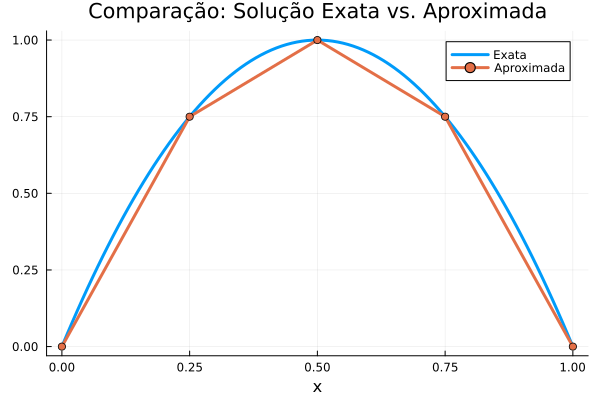

In [8]:
# Carrega o exemplo escolhido
exemplo = 3
α, β, f, u = dados_de_entrada(exemplo)

# Define o número de nós internos na malha
N = 3

# Constrói a matriz K e o vetor F
K = monta_K(α, β, N)
F = monta_F(f, N)

# Exibe a matriz K (sistema linear) e o vetor F (vetor força)
display("Matriz K:")
display(K)
display("Vetor F:")
display(F)

# Resolve o sistema linear K * c = F para obter os coeficientes solução aproximada u_h(x)
c = K \ F
display("Solução aproximada U:")
display(c)

# Exibe a solução exata nos nos internos da malha
display("Solução exata nos nós internos:")
h = 1.0 / (N + 1)  # Tamanho do passo
display(u.(h:h:1-h))

# Define a discretização da malha com N nós internos, incluindo os pontos de fronteira
malha = LinRange(0, 1, N+2)

# Gera o gráfico comparando a solução aproximada com a solução exata
plt = plot(0:0.01:1, u.(0:0.01:1), label="Exata", lw=3, title="Comparação: Solução Exata vs. Aproximada")
plot!(plt, malha, [0; c; 0], label="Aproximada", lw=3, linestyle=:solid, markershape=:circle) # O "!" adiciona ao gráfico existente
xlabel!("x")  # Adiciona o rótulo ao eixo x

# Exibe o gráfico final
display(plt)

## Cálculo do erro

O erro entre a solução exata e aproximada na norma do espaço $L^2(]0,1[)$ é dado por

\begin{align*}
    \|u-u_h\|=\sqrt{\int_0^1|u(x)-u_h(x)|^2dx }.
\end{align*}

Dessa forma, denotando $\mathcal{E}_h=\|u-u_h\|$, note que:

\begin{align*}
 \mathcal{E}_h^2 =& \int_0^1 |u(x)-u_h(x)|^2 dx 
 \\[7pt]
 =& \sum_{i=1}^{m+1} \int_{x_{i-1}}^{x_{i}} |u(x)-u_h(x)|^2 dx 
 \\[7pt]
 =& \sum_{i=1}^{m+1} \int_{x_{i-1}}^{x_{i}} |u(x) - \sum_{j=1}^{m} c_j\varphi_j(x) |^2 dx 
 \\[7pt]
=&\int_{x_0}^{x_1} |u(x) - c_1\varphi_1(x) |^2 dx
+ \sum_{i=2}^{m} \int_{x_{i-1}}^{x_{i}} | u(x) - c_{i-1}\varphi_{i-1}(x) - c_{i}\varphi_{i}(x) |^2 dx 
+ \int_{x_{m}}^{x_{m+1}} | u(x) - c_{m}\varphi_{m}(x) |^2 dx
\\[7pt]
=&\frac{h}{2}\left[\int_{-1}^{1} |u\big(x(\xi,1)\big) - c_1\phi_2(\xi) |^2 d\xi
+ \sum_{i=2}^{m} \int_{-1}^{1} |u\big(x(\xi,i)\big) - c_{i-1}\phi_1(\xi) - c_{i}\phi_2(\xi) |^2 d\xi
+ \int_{-1}^{1} |u\big(x(\xi,m+1)\big) - c_{m}\phi_1(\xi) |^2 d\xi\right].
\end{align*}

Daí, aplicando quadratura gaussiana, obtemos:

\begin{align*}
 \mathcal{E}_h^2 =& 
\frac{h}{2}\left[
\sum_{j=1}^{n_{pg}} W_j|u\big(x(P_j,1)\big) - c_1\phi_2(P_j) |^2
+ \sum_{i=2}^{m} \sum_{j=1}^{n_{pg}} W_j|u\big(x(P_j,i)\big) - c_{i-1}\phi_1(P_j) - c_{i}\phi_2(P_j) |^2
+ \sum_{j=1}^{n_{pg}}  W_j|u\big(x(P_j,m+1)\big) - c_{m}\phi_1(P_j) |^2 \right].
\end{align*}

In [9]:
"Calcula o erro L2 entre a solução exata `u` e a solução aproximada `u_h` representada pelos coeficientes `c`."
function erroL2(u,c)
    m = length(c)      # Número de nós internos na malha
    h = 1.0 / (m + 1)  # Tamanho do passo
    P, W = legendre(5) # Pontos e pesos de quadratura de Gauss-Legendre
    erro = 0.0         # Inicializa o erro

    # Calcula o erro no primeiro intervalo
    for j = 1:5
        x = x_de_ξ(P[j],1,h)
        erro += W[j] * ( u(x) - c[1] * ϕ(P[j],2) )^2
    end
    # Calculo o erro nos intervalos internos
    for i = 2:m
        for j = 1:5
            x = x_de_ξ(P[j],i,h)
            erro += W[j] * ( u(x) - c[i-1] * ϕ(P[j],1) - c[i] * ϕ(P[j],2) )^2
        end
    end
    # Calcula o erro no último intervalo
    for j = 1:5
        x = x_de_ξ(P[j],m+1,h)
        erro += W[j] * ( u(x) - c[m] * ϕ(P[j],1) )^2
    end
    
    return sqrt(erro * h/2)
end

erroL2

In [10]:
# Calcula o erro na norma do máximo entre a solução exata e a solução aproximada nos nós internos
erro_max = maximum(abs.(u.(h:h:1-h) - c))
display("Erro na norma do máximo:")
display(erro_max)

# Calcula o erro L2 entre a solução exata e a solução aproximada
erro_L2 = erroL2(u,c)
display("Erro na norma L2:")
display(erro_L2)

"Erro na norma do máximo:"

3.3306690738754696e-16

"Erro na norma L2:"

0.04564354645876402

## Estudo da convergência do erro

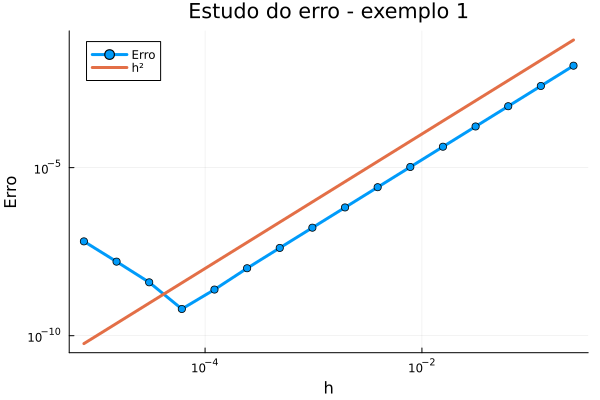

"Tabela com os valores de h e erro - exemplo 1"

Row,h,erro
,Float64,Float64
1,0.25,0.010743
2,0.125,0.00267787
3,0.0625,0.000668977
4,0.03125,0.000167214
5,0.015625,4.18015e-5
6,0.0078125,1.04503e-5
7,0.00390625,2.61256e-6
8,0.00195312,6.53138e-7
9,0.000976562,1.63281e-7


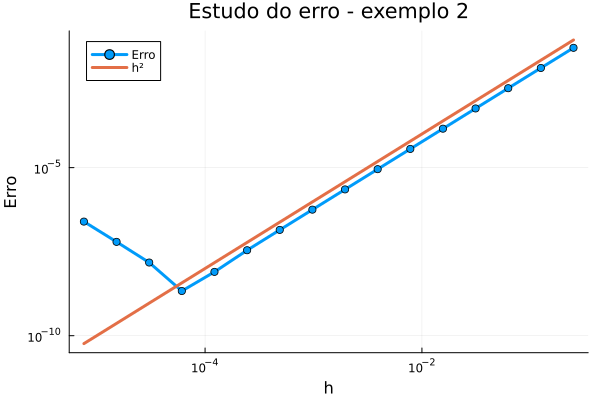

"Tabela com os valores de h e erro - exemplo 2"

Row,h,erro
,Float64,Float64
1,0.25,0.0365421
2,0.125,0.00918215
3,0.0625,0.00229843
4,0.03125,0.000574787
5,0.015625,0.000143708
6,0.0078125,3.59277e-5
7,0.00390625,8.98196e-6
8,0.00195312,2.24549e-6
9,0.000976562,5.6136e-7


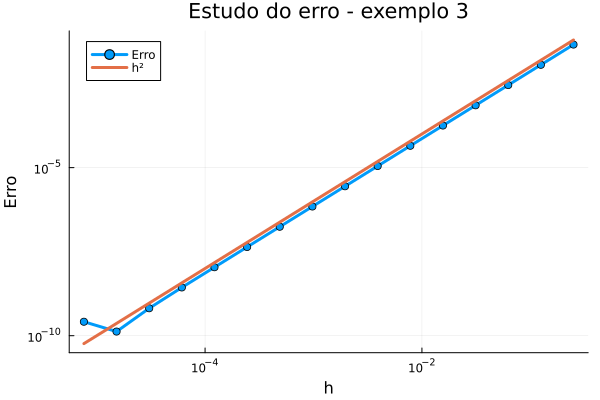

"Tabela com os valores de h e erro - exemplo 3"

Row,h,erro
,Float64,Float64
1,0.25,0.0456435
2,0.125,0.0114109
3,0.0625,0.00285272
4,0.03125,0.00071318
5,0.015625,0.000178295
6,0.0078125,4.45738e-5
7,0.00390625,1.11434e-5
8,0.00195312,2.78586e-6
9,0.000976562,6.96465e-7


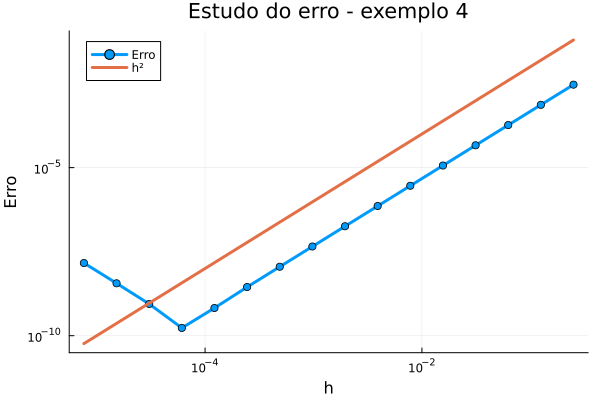

"Tabela com os valores de h e erro - exemplo 4"

Row,h,erro
,Float64,Float64
1,0.25,0.00292992
2,0.125,0.000736338
3,0.0625,0.000184325
4,0.03125,4.60964e-5
5,0.015625,1.1525e-5
6,0.0078125,2.88132e-6
7,0.00390625,7.20334e-7
8,0.00195312,1.80084e-7
9,0.000976562,4.50203e-8


In [11]:
function estudo_do_erro_galerkin(exemplo)
    # Carrega o exemplo escolhido
    α, β, f, u = dados_de_entrada(exemplo)
    # Define os valores de N a serem considerados
    vec_N = [2^i-1 for i in 2:17]
    # Inicializa o vetor para armazenar os erros
    vec_erros = zeros(length(vec_N))
    # Calcula o erro para cada valor de N
    for i = 1:length(vec_N)
        N = vec_N[i]
        h = 1.0 / (N+1)
        K = monta_K(α, β, N)
        F = monta_F(f, N)
        c = K \ F
        # vec_erros[i] = maximum(abs.(u.(h:h:1-h)-c))
        vec_erros[i] = erroL2(u,c)
    end
    # Exibe o gráfico do erro em função dos h's em escala logarítmica
    h = 1.0 ./ (vec_N .+ 1) # Calcula o tamanho do passo h para cada N
    plt = plot(h, vec_erros, lw=3, linestyle=:solid, markershape=:circle, label="Erro", title="Estudo do erro - exemplo "*string(exemplo),  xscale=:log10, yscale=:log10, legend=:topleft) # Gráfico do erro
    plot!(plt, h, h.^2, lw=3, linestyle=:solid, label="h²")# Adiciona a curva h² ao gráfico
    xlabel!("h")     # Adiciona o rótulo ao eixo x 
    ylabel!("Erro")  # Adiciona o rótulo ao eixo y
    display(plt)     # Exibe o gráfico
    # Exibir a tabela com os valores de h e erro
    display("Tabela com os valores de h e erro - exemplo "*string(exemplo))
    display(DataFrame(h=h, erro=vec_erros))
end

estudo_do_erro_galerkin(1)
estudo_do_erro_galerkin(2)
estudo_do_erro_galerkin(3)
estudo_do_erro_galerkin(4)

# Galerkin - versão 2

## Cálculo da matriz local $K^e$ - via quadratura gaussiana

\begin{align*}
K^e_{a,b} 
& = 
  \alpha \int_{x_{1}^e}^{x_2^e}\frac{d\varphi_a^e}{dx}(x)\frac{d\varphi_b^e}{dx}(x)dx
+ \beta  \int_{x_{1}^e}^{x_2^e}\varphi_a^e(x)\varphi_b^e(x)dx
\\[5pt]
& =
\alpha \int_{-1}^{1}
\frac{d\varphi_a^e}{dx}\big(x(\xi,e)\big)\frac{d\varphi_b^e}{dx}\big(x(\xi,e)\big)\frac{h}{2} d\xi
+ \beta  \int_{-1}^{1}
\varphi_a^e\big(x(\xi,e)\big)\varphi_b^e\big(x(\xi,e)\big)\frac{h}{2} d\xi
\\[5pt]
& =
\alpha \int_{-1}^{1}
\frac{d\phi_a}{d\xi}(\xi)\frac{2}{h}\frac{d\phi_b}{d\xi}(\xi)\frac{2}{h}\frac{h}{2} d\xi
+ \beta  \int_{-1}^{1}
\phi_a(\xi)\phi_b(\xi)\frac{h}{2} d\xi
\\[5pt]
& =
\frac{2\alpha}{h} \int_{-1}^{1}
\frac{d\phi_a}{d\xi}(\xi)\frac{d\phi_b}{d\xi}(\xi)d\xi
+ \frac{\beta h}{2}  \int_{-1}^{1}
\phi_a(\xi)\phi_b(\xi) d\xi
\\[5pt]
& =
\frac{2\alpha}{h} \sum_{j=1}^{n_{pg}} W_j \frac{d\phi_a}{d\xi}(P_j)\frac{d\phi_b}{d\xi}(P_j)
+ \frac{\beta h}{2} \sum_{j=1}^{n_{pg}} W_j \phi_a(P_j)\phi_b(P_j).
\end{align*}

In [12]:
"Retorna a derivada de 'ϕ' em relação a 'ξ' para um dado 'ξ' e 'a'."
function dϕ(ξ, a)
    if a == 1
        return -1.0 / 2.0
    elseif a == 2
        return 1.0 / 2.0
    else
        error("a deve ser 1 ou 2.")
    end
end

"Retorna a matriz local `Kᵉ` de um elemento arbitrário `e` de tamanho `h`."
function monta_Kᵉ(α,β,h)
    # Define as constantes que acompanham α e β
    cst1 = 2.0 * α / h
    cst2 = β * h / 2.0
    # Define os pontos e pesos de quadratura de Gauss-Legendre
    n_pg = 2
    P, W = legendre(n_pg)
    # Inicializa a matriz local Kᵉ
    Kᵉ = zeros(2,2)
    # Loop sobre as entradas da matriz local Kᵉ
    for a = 1:2
        for b = 1:2
            # Loop sobre os pontos de quadratura
            for j = 1:n_pg
                # Calcula a contribuição da quadratura na entrada Kᵉ[a,b]
                Kᵉ[a,b] += W[j] * ( cst1 * dϕ(P[j],a) * dϕ(P[j],b) + cst2 * ϕ(P[j],a) * ϕ(P[j],b) )
            end
        end
    end
    # Retorna a matriz local Kᵉ
    return Kᵉ
end

monta_Kᵉ

## Montagem da matriz global $K$ a partir da matriz local $K^e$

In [13]:
"Constrói e retorna a matriz tridiagonal simétrica `K` de tamanho `m x m` a partir da matriz local `Kᵉ`."
function monta_K_vs2(α, β, m)
    h = 1.0 / (m+1)        # Tamanho do passo
    K = spzeros(m, m)      # Inicializa a matriz esparsa K
    Kᵉ = monta_Kᵉ(α, β, h) # Calcula a matriz local Kᵉ
    # Loop sobre os elementos internos
    for e = 2:m
        K[e-1:e,e-1:e] += Kᵉ # Adiciona a contribuição do elemento e na matriz K
    end
    # Adiciona as contribuições dos elementos 1 e m+1
    K[1,1] += Kᵉ[2,2] # Contribuição do elemento 1
    K[m,m] += Kᵉ[1,1] # Contribuição do elemento m+1
    # Retorna a matriz K
    return K
end

monta_K_vs2

## Cálculo do vetor local $F^e$ - via quadratura gaussiana

\begin{align*}
F_a^e 
& = 
\int_{x_1^e}^{x_2^e}f(x)\varphi_a^e(x)dx
\\[5pt]
& =
\int_{-1}^{1}f\big(x(\xi,e)\big)\varphi_a^e\big(x(\xi,e)\big)\frac{h}{2}d\xi
\\[5pt]
& =
\frac{h}{2} \int_{-1}^{1}f\big(x(\xi,e)\big)\phi_a(\xi)d\xi
\\[5pt]
& \approx
\frac{h}{2} \sum_{j=1}^{n_{pg}} W_j f\big(x(P_j,e)\big)\phi_a(P_j).
\end{align*}

In [14]:
"Monta o vetor força local `Fᵉ` referente ao elemento `e` de tamanho `h`."
function monta_Fᵉ(f::Function, h::Float64, e::Int) :: Vector{Float64}
    Fᵉ = zeros(2)       # Inicializa o vetor força local Fᵉ
    P, W = legendre(5)  # Define 5 pontos de quadratura de Gauss-Legendre
    # Loop sobre as entradas do vetor força local Fᵉ
    for a = 1:2
        # Loop sobre os pontos de quadratura
        for j = 1:5
            # Cálculo da coordenada em x correspondente ao ponto de quadratura P[j]
            x = x_de_ξ(P[j],e,h)
            # Calcula e acumula a contribuição da quadratura no vetor Fᵉ[a]
            Fᵉ[a] += W[j] * f(x) * ϕ(P[j],a) * h/2
        end
    end
    # Retorna o vetor força local Fᵉ
    return Fᵉ
end

monta_Fᵉ

## Montagem do vetor global $F$ a partir do vetor local $F^e$

In [15]:
"Monta e retorna o vetor força `F` de tamanho `m`, utilizando os vetores locais `Fᵉ`. "
function monta_F_vs2(f::Function, m::Int) :: Vector{Float64}
    h = 1.0 / (m + 1)  # Tamanho do passo
    F = zeros(m)       # Inicializa o vetor F
    
    # Loop sobre os elementos internos
    for e = 2:m
        F[e-1:e] += monta_Fᵉ(f,h,e) # Adiciona a contribuição do elemento e no vetor F
    end
    # Adiciona as contribuições dos elementos 1 e m+1
    F[1] += monta_Fᵉ(f,h,1)[2]   # Contribuição do elemento 1
    F[m] += monta_Fᵉ(f,h,m+1)[1] # Contribuição do elemento m+1

    return F
end

monta_F_vs2

## Comparando a solução aproximada com a solução exata

"Matriz K:"

3×3 SparseMatrixCSC{Float64, Int64} with 7 stored entries:
  8.0  -4.0    ⋅ 
 -4.0   8.0  -4.0
   ⋅   -4.0   8.0

"Vetor F:"

3-element Vector{Float64}:
 1.9999999999999996
 1.9999999999999996
 1.9999999999999996

"Solução aproximada U:"

3-element Vector{Float64}:
 0.7499999999999998
 0.9999999999999997
 0.7499999999999998

"Solução exata nos nós internos:"

3-element Vector{Float64}:
 0.75
 1.0
 0.75

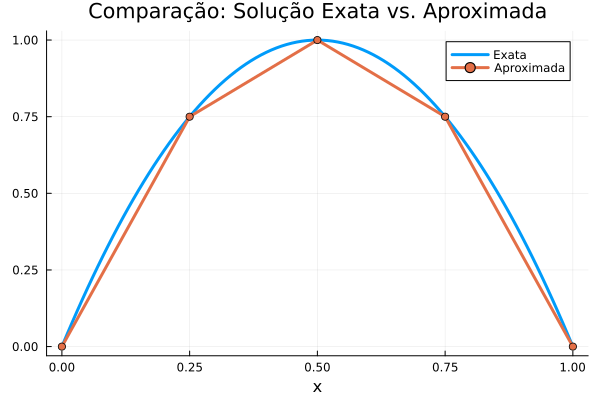

In [16]:
# Carrega o exemplo escolhido
exemplo = 3
α, β, f, u = dados_de_entrada(exemplo)

# Define o número de nós internos na malha
N = 3

# Constrói a matriz K e o vetor F
K = monta_K_vs2(α, β, N)
F = monta_F_vs2(f, N)

# Exibe a matriz K (sistema linear) e o vetor F (vetor força)
display("Matriz K:")
display(K)
display("Vetor F:")
display(F)

# Resolve o sistema linear K * c = F para obter os coeficientes solução aproximada u_h(x)
c = K \ F
display("Solução aproximada U:")
display(c)

# Exibe a solução exata nos nos internos da malha
display("Solução exata nos nós internos:")
h = 1.0 / (N + 1)  # Tamanho do passo
display(u.(h:h:1-h))

# Define a discretização da malha com N nós internos, incluindo os pontos de fronteira
malha = LinRange(0, 1, N+2)

# Gera o gráfico comparando a solução aproximada com a solução exata
plt = plot(0:0.01:1, u.(0:0.01:1), label="Exata", lw=3, title="Comparação: Solução Exata vs. Aproximada")
plot!(plt, malha, [0; c; 0], label="Aproximada", lw=3, linestyle=:solid, markershape=:circle) # O "!" adiciona ao gráfico existente
xlabel!("x")  # Adiciona o rótulo ao eixo x

# Exibe o gráfico final
display(plt)

## Estudo da convergência do erro

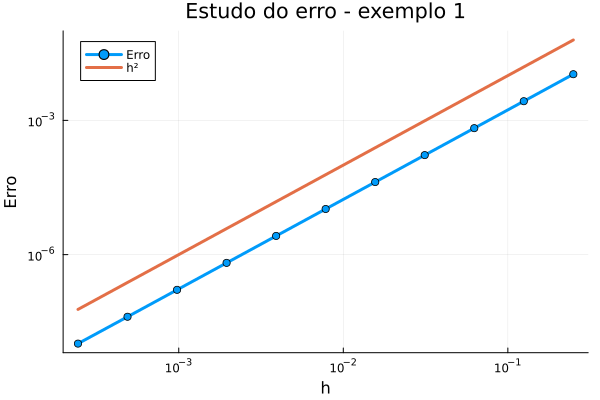

"Tabela com os valores de h e erro - exemplo 1"

Row,h,erro
,Float64,Float64
1,0.25,0.010743
2,0.125,0.00267787
3,0.0625,0.000668977
4,0.03125,0.000167214
5,0.015625,4.18015e-5
6,0.0078125,1.04503e-5
7,0.00390625,2.61256e-6
8,0.00195312,6.53138e-7
9,0.000976562,1.63288e-7


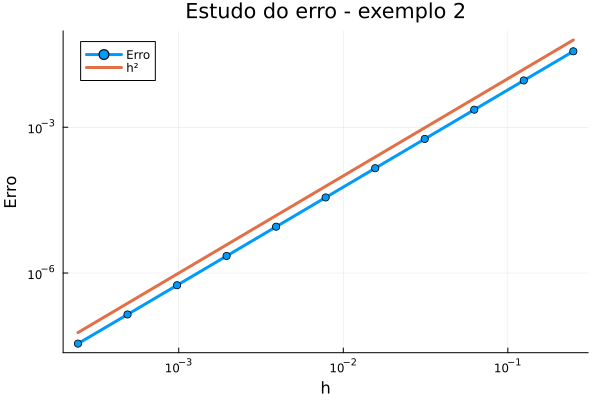

"Tabela com os valores de h e erro - exemplo 2"

Row,h,erro
,Float64,Float64
1,0.25,0.0365421
2,0.125,0.00918215
3,0.0625,0.00229843
4,0.03125,0.000574787
5,0.015625,0.000143708
6,0.0078125,3.59277e-5
7,0.00390625,8.98196e-6
8,0.00195312,2.24549e-6
9,0.000976562,5.61387e-7


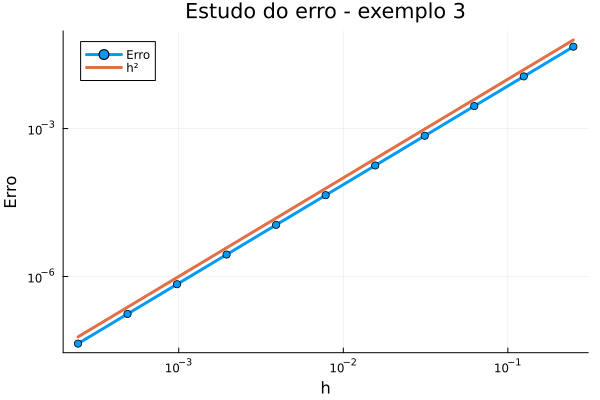

"Tabela com os valores de h e erro - exemplo 3"

Row,h,erro
,Float64,Float64
1,0.25,0.0456435
2,0.125,0.0114109
3,0.0625,0.00285272
4,0.03125,0.00071318
5,0.015625,0.000178295
6,0.0078125,4.45738e-5
7,0.00390625,1.11434e-5
8,0.00195312,2.78586e-6
9,0.000976562,6.96465e-7


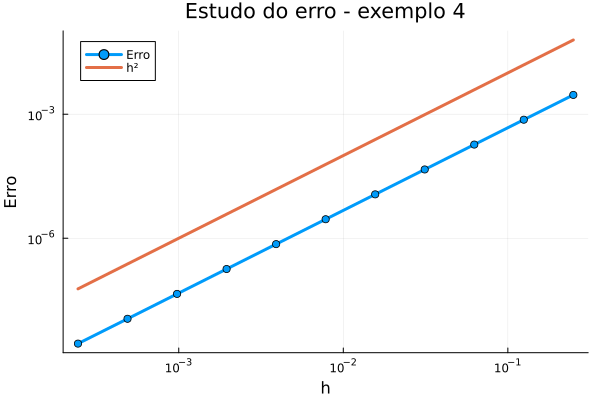

"Tabela com os valores de h e erro - exemplo 4"

Row,h,erro
,Float64,Float64
1,0.25,0.00292992
2,0.125,0.000736338
3,0.0625,0.000184325
4,0.03125,4.60964e-5
5,0.015625,1.1525e-5
6,0.0078125,2.88132e-6
7,0.00390625,7.20334e-7
8,0.00195312,1.80084e-7
9,0.000976562,4.50215e-8


In [17]:
function estudo_do_erro_galerkin_vs2(exemplo)
    # Carrega o exemplo escolhido
    α, β, f, u = dados_de_entrada(exemplo)
    # Define os valores de N a serem considerados
    vec_N = [2^i-1 for i in 2:12]
    # Inicializa o vetor para armazenar os erros
    vec_erros = zeros(length(vec_N))
    # Calcula o erro para cada valor de N
    for i = 1:length(vec_N)
        N = vec_N[i]
        h = 1.0 / (N+1)
        K = monta_K_vs2(α, β, N)
        F = monta_F_vs2(f, N)
        c = K \ F
        # vec_erros[i] = maximum(abs.(u.(h:h:1-h)-c))
        vec_erros[i] = erroL2(u,c)
    end
    # Exibe o gráfico do erro em função dos h's em escala logarítmica
    h = 1.0 ./ (vec_N .+ 1) # Calcula o tamanho do passo h para cada N
    plt = plot(h, vec_erros, lw=3, linestyle=:solid, markershape=:circle, label="Erro", title="Estudo do erro - exemplo "*string(exemplo),  xscale=:log10, yscale=:log10, legend=:topleft) # Gráfico do erro
    plot!(plt, h, h.^2, lw=3, linestyle=:solid, label="h²")# Adiciona a curva h² ao gráfico
    xlabel!("h")     # Adiciona o rótulo ao eixo x 
    ylabel!("Erro")  # Adiciona o rótulo ao eixo y
    display(plt)     # Exibe o gráfico
    # Exibir a tabela com os valores de h e erro
    display("Tabela com os valores de h e erro - exemplo "*string(exemplo))
    display(DataFrame(h=h, erro=vec_erros))
end

estudo_do_erro_galerkin_vs2(1)
estudo_do_erro_galerkin_vs2(2)
estudo_do_erro_galerkin_vs2(3)
estudo_do_erro_galerkin_vs2(4)